# Zwei-Machinen-Flow-Shop-Problem mit Branch-and-Bound

## Zwei-Machinen-Flow-Shop-Problem

Beim Flow-Shop Problem ist ein Optimierungsproblem. Die Annahmen des Problems sind: 
* Man hat diverse Jobs, die nacheinander auf zwei Maschinen durchgeführt werden müssen. 
* Die Jobs beanspruchen die Maschinen für eine unterschiedliche Dauer. 
* Man kann erst mit einem Job auf Maschine 2 beginnen, wenn der Job auf Maschine 1 beendet wurde.

Ziel des Problems ist die Minimierung der durchnittliche Fertigstellungszeit der Jobs, was äquivalent ist zur Minimierung der Summe der Fertigstellungszeiten. 

## Branch-and-Bound

Im Prinzip könnte man ein kombinatorisches Problem so lösen, dass man für alle
zulässigen Lösungen (es gibt ja nur endlich viele) die Zielfunktion bestimmt und das
Minimum nimmt. Dies bezeichnet man als vollständige Enumeration. In der Praxis
ist vollständige Enumeration aus Laufzeitgründen meist undurchführbar. Es ist daher
in der Regel nötig, die Menge der zulässigen Lösungen, deren Zielfunktionswert
man bestimmt, einzuschränken. 
\
Bei Branch-and-Bound wird das Optimierungsproblem im Branch Schritt in Teilprobleme zerlegt. Für diese wird im Bound Schritt eine untere Schranke bestimmt. Nun wird das Teilproblem mit der niedrigsten Schranke wieder in Teilproblem zerlegt und von diesen wieder eine untere Schranke bestimmt. 
\
Diese Schritte werden solange durchgeführt bis man eine Lösung gefunden hat und es kein Teilproblem mit einer unteren Schranke gibt, die unter der der Lösung liegt.



Im konkreten Zwei-Machinen-Flow-Shop-Problem ist der Branch Schritt, dass man die Durchführung des nächsten Job auf der Maschine 1 festlegt und der Bound Schritt, dass man gegeben dieses Jobs eine untere Schranke bestimmt. Die untere Schranke wird berechnet durch die Aufsummierung der Fertigstellungszeit der Jobs, dabei wird ignoriert ob ein Job bereits auf Maschine 1 beendet wurde. Falls es keine Überschneidungen gibt, stellt die untere Schranke eine mögliche Lösung dar.

In [148]:
import flow_job
from graphviz import Digraph
import ipysheet
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style

## Einfaches Beispiel

In [149]:
number_jobs = 4
q = list(np.random.randint(1, 15, size=number_jobs, dtype='l'))
p = list(np.random.randint(1, 15, size=number_jobs, dtype='l'))
job_list=[[x,y] for x,y in zip(q,p)]
print("Job Liste: {}".format(job_list))

Job Liste: [[7, 6], [1, 13], [2, 8], [13, 11]]


In [150]:
bb_tree = flow_job.FlowShop(job_list)

In [151]:
bs_order = bb_tree.solution.order
bs_value = bb_tree.solution.lb_value
bs_iter = bb_tree.iterations
bs_plan = bb_tree.solution.machine_plan

**optimal Solution:**

In [152]:
print("Job Reihenfolge: {}".format(bs_order))
print("Summe der Fertigstellungszeiten: {}".format(bs_value))
print("Notwendige Iterationen bis zu einer Lösung: {}".format(bs_iter))

Job Reihenfolge: [3, 1, 2, 4]
Summe der Fertigstellungszeiten: 91
Notwendige Iterationen bis zu einer Lösung: 5


### Visualisierung der Maschinenbelegung

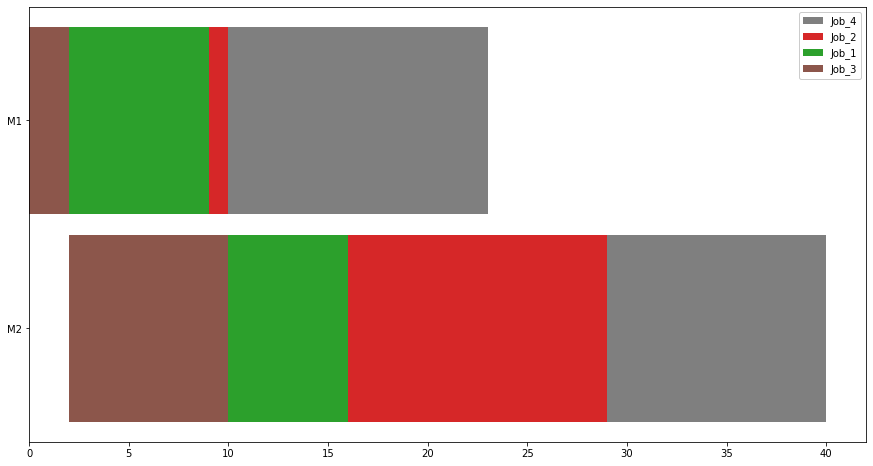

In [153]:
x = [[int(j) for j in list(i)] for i in bs_plan]
plt.figure(figsize=(15,8))
ind = [1,0]
width = 0.9
sum_dur_0 = len(x[0])
sum_dur_1 = len(x[1])

color = plt.get_cmap('tab10')(
        np.linspace(0.20, 0.70, number_jobs))

plt1 = plt.barh(ind, [sum_dur_0, 0], width, color = color[x[0][sum_dur_0-1]-1],label='Job_{0}'.format(str(x[0][sum_dur_0-1])))

for i in reversed(range(0,sum_dur_0-1)):
    if x[0][i] != x[0][i+1]:
        if x[0][i] == 0:
            plt1 = plt.barh(ind, [i+1,0], width, color='white')
        else:
            plt1 = plt.barh(ind, [i+1,0], width, color = color[x[0][i]-1],label='Job_{0}'.format(str(x[0][i])))


plt1 = plt.barh(ind, [0,sum_dur_1], width, color = color[x[1][sum_dur_1-1]-1])

for i in reversed(range(0,sum_dur_1-1)):
    if x[1][i] != x[1][i+1]:
        if x[1][i] == 0:
            plt1 = plt.barh(ind, [0,i+1], width, color='white')
        else:
            plt1 = plt.barh(ind, [0,i+1], width, color = color[x[1][i]-1])

plt.yticks(ind, ('M1', 'M2'))
plt.legend(framealpha=1, frameon=True)
plt.show()

Diese Grafik zeigt zu welchem Zeitpunkt welcher Job auf welcher Maschine durchgeführt wird.

### Visualisierung des Branch-and-Bound Verfahrens

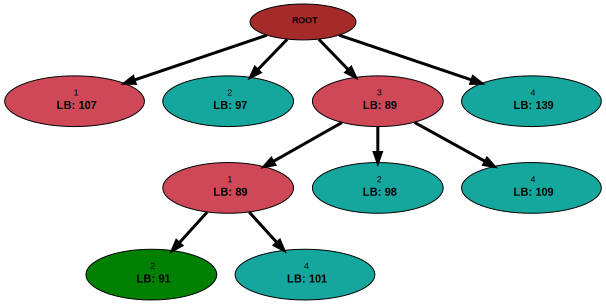

In [154]:

cvals  = [0, 1]
colors = ['#CF4858', '#15A79D']

tuples = list(zip(cvals, colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    
g = Digraph()
g.attr(size='10')
g.attr('node', penwidth='1', fontsize='1', fontname='Arial')
g.attr('node', pencolor='green')
g.attr('edge', penwidth='3')
g.node('root', 
           '''<<TABLE CELLBORDER="0" BORDER="0" CELLPADDING="0">
                   <TR>
                       <TD>
                           <FONT POINT-SIZE="9"><B>ROOT</B></FONT>
                       </TD>
                   </TR>
                </TABLE>>''',
           style='filled',
           pencolor='#80628B',
           fillcolor='brown')
for node in bb_tree.nodes:
    if ((node.valid) & (node.lb_value==bs_value)):
        fcolor="green"
    elif node.valid:
        fcolor='#15A79D'
    else:
        fcolor='#CF4858'
    g.node(str(node), 
           '''<<TABLE CELLBORDER="0" BORDER="0" CELLPADDING="0">
                   <TR>
                       <TD>
                           <FONT POINT-SIZE="9">{0}</FONT>
                       </TD>
                   </TR>
                   <TR>
                       <TD>
                           <FONT POINT-SIZE="11"><B>LB: {1:.{prec}f}</B></FONT>
                       </TD>
                   </TR>
                </TABLE>>'''.format(node.nextjob, node.lb_value, prec=0),
           style='filled',
           pencolor='#80628B',
           fillcolor=fcolor)

########################################################################################################################

for node in bb_tree.nodes:
    g.edge(str(node.parent),str(node))

g


Jede Kugel stellt einen Branch Schritt dar. Falls die untere Schranke des Branch Schrittes eine mögliche Lösung ist, ist diese Türkis gefärbt, sonst rot. Die grün eingefärbte Kugel stellt die optimale Lösung dar.

## Dauer der Berechnung bei zunehmender Anzahl der Jobs

In [155]:
times = []
for i in range(1,10):
    onetime=[]
    for j in range(10):
        q = list(np.random.randint(1, 100, size=i, dtype='l'))
        p = list(np.random.randint(1, 100, size=i, dtype='l'))
        job_list=[[x,y] for x,y in zip(q,p)]
        ts = time.time()
        flow_job.FlowShop(job_list)
        te = time.time()
        onetime.append((te - ts) * 1000)
    times.append(onetime)
    print(i)


1
2
3
4
5
6
7
8
9


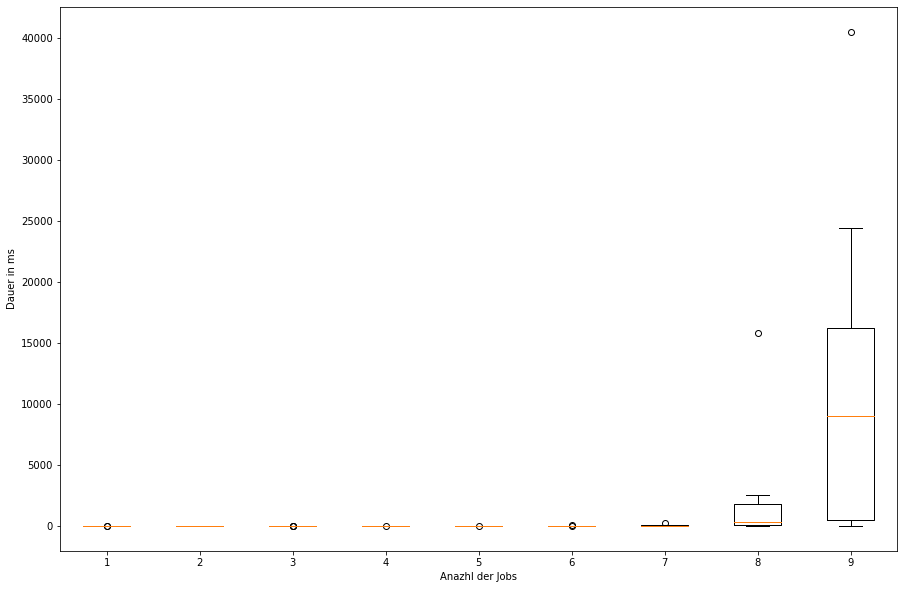

In [156]:
plt.figure(figsize=(15,10))
plt.boxplot(times)
plt.ylabel('Dauer in ms')
plt.xlabel('Anazhl der Jobs')

plt.show()

An der Grafik erkennt man sehr schön, dass mit der Anzahl der Jobs, die notwendige Zeit um diese zu lösen exponentiell steigt.